# So you finished a Marathon? Now what?

Well if you're my way inclined, the obvious answer it to get all the available data and make it look nice... so here are the outputs.

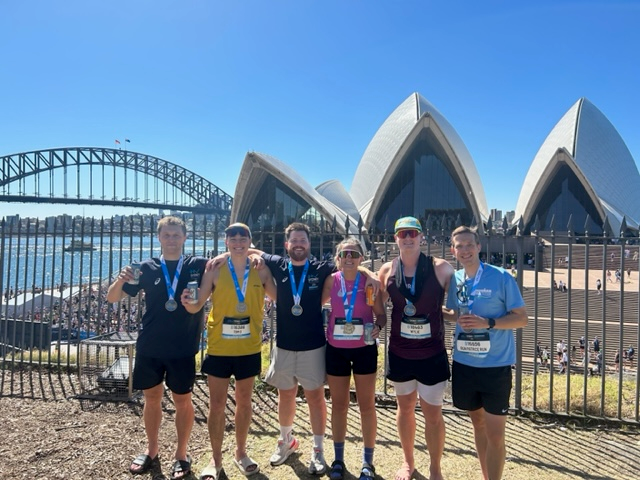

In [1]:
# Import all required packages
import os
import csv
import json
import gpxpy
import calmap
import requests
import gpxpy.gpx
import mplcursors
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from geopy.distance import great_circle
from pandas.io.json import json_normalize

## Starting with the strava data
Need to create a strava app to access the strava api.

Once this is set up we can authorise the app with each account and collect the data

In [42]:
# Required inputs to authorise the app
client_id = '#####'
client_secret = '########'
runner_code = 'ac8c5c7649db56cc696e6c6699ce31833b15c34b'

In [43]:
# Make Strava auth API call with  
# client_code, client_secret and code
response = requests.post(
                    url = 'https://www.strava.com/oauth/token',
                    data = {
                            'client_id': client_id,
                            'client_secret': client_secret,
                            'code': runner_code,
                            'grant_type': 'authorization_code'
                            }
                )
#Save json response as a variable
strava_tokens = response.json()

# Save tokens to file
with open('strava_tokens.json', 'w') as outfile:
    json.dump(strava_tokens, outfile)

# Open JSON file and print the file contents to check it's worked properly
with open('strava_tokens.json') as check:
  data = json.load(check)
print(data)

{'token_type': 'Bearer', 'expires_at': 1695189393, 'expires_in': 21600, 'refresh_token': '04ea7b50cfc6e53552fbf5c8c5c71571d5a2c747', 'access_token': '9c6869c5466d5101c12d2bfcbdf6aa6cf8427c5b', 'athlete': {'id': 25234086, 'username': None, 'resource_state': 2, 'firstname': 'Jonny', 'lastname': 'Burns', 'bio': None, 'city': 'Sydney ', 'state': '', 'country': None, 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2017-09-24T09:15:10Z', 'updated_at': '2023-09-19T00:55:44Z', 'badge_type_id': 1, 'weight': 0.0, 'profile_medium': 'https://graph.facebook.com/10154682857921924/picture?height=256&width=256', 'profile': 'https://graph.facebook.com/10154682857921924/picture?height=256&width=256', 'friend': None, 'follower': None}}


In [44]:
# Set page number
page = 1

# Get the tokens from file to connect to Strava
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)

# Loop through all activities
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']

# Get first page of activities from Strava with all fields
r = requests.get(url + '?access_token=' + access_token + '&per_page=200' + '&page=' + str(page))
r = r.json()

# Normalise the JSON
df = json_normalize(r)

# Save Dataframe to csv
df.to_csv(r"C###\strava\Running\runner_strava.csv")

C:\Users\e014694\AppData\Local\Temp\ipykernel_31124\360737436.py:16: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.



### Collate all data from Rob's disperate recording :(

#### Asics
##### Asics provided data in an excel format but elevation was missing, so used the segments and cordinates to manually calculate these

In [7]:
# Function to calculate distance between two points in the GPX track
def calculate_length(track_segment):
    length = 0
    for i in range(1, len(track_segment.points)):
        point1 = track_segment.points[i - 1]
        point2 = track_segment.points[i]
        length += great_circle((point1.latitude, point1.longitude), (point2.latitude, point2.longitude)).meters
    return length

# Function to calculate elevation gain in the GPX track segment
def calculate_elevation_gain(track_segment):
    elevation_gain = 0
    previous_elevation = None

    for point in track_segment.points:
        if previous_elevation is None:
            previous_elevation = point.elevation
        else:
            current_elevation = point.elevation
            if current_elevation > previous_elevation:
                elevation_gain += current_elevation - previous_elevation
            previous_elevation = current_elevation

    return elevation_gain

# Function to convert GPX time format to minutes
def gpx_time_to_minutes(gpx_time):
    gpx_time = gpx_time.replace(tzinfo=None)  # Remove timezone info
    return (gpx_time - datetime(1970, 1, 1)).total_seconds() / 60

# Function to process a single GPX file and return a dictionary of summary data
def process_gpx_file(gpx_file_path):
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    total_length = 0
    total_duration = 0
    total_elevation_gain = 0

    for track in gpx.tracks:
        for segment in track.segments:
            length = calculate_length(segment)
            elevation_gain = calculate_elevation_gain(segment)
            start_time = segment.points[0].time
            end_time = segment.points[-1].time
            duration_minutes = gpx_time_to_minutes(end_time) - gpx_time_to_minutes(start_time)
            total_length += length
            total_elevation_gain += elevation_gain
            total_duration += duration_minutes

    return {
        'File': os.path.basename(gpx_file_path),
        'Start Date': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'Total Length (meters)': total_length,
        'Total Elevation Gain (meters)': total_elevation_gain,
        'Total Duration (minutes)': total_duration
    }

# Folder containing GPX files
gpx_folder = r"###\strava\Rob\asics_run"  # Replace with the path to your folder of GPX files

# Initialize a list to store the summary data for all GPX files
all_summary_data = []

# Iterate through GPX files in the folder
for filename in os.listdir(gpx_folder):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_folder, filename)
        summary_data = process_gpx_file(gpx_file_path)
        all_summary_data.append(summary_data)

# Create a DataFrame from the summary data
df = pd.DataFrame(all_summary_data)

# Write df to dataframe
df.to_csv(r"###\strava\Rob\asics_run\rob_asics.csv")

In [7]:
rob_asics = pd.read_csv(r"###\strava\Rob\asics_run\rob_asics.csv")

rob_asics = rob_asics[[
    'Start Date',
    'Total Length (meters)',
    'Total Duration (minutes)',
    'Total Elevation Gain (meters)'
]]

rob_asics = rob_asics.rename(columns = {
        'Start Date' : 'start_date_local',
        'Total Length (meters)' : 'distance',
        'Total Duration (minutes)' : 'moving_time',
        'Total Elevation Gain (meters)' : 'total_elevation_gain'
})
rob_asics['Runner'] = 'Rob'
rob_asics['type'] = 'Run'

rob_asics['Date'] = pd.to_datetime(rob_asics['start_date_local']).dt.date

In [8]:
rob_asics.head(10)

,start_date_local,distance,moving_time,total_elevation_gain,Runner,type,Date
0,2023-05-17 08:31:10,6477.902319,35.666667,65.7,Rob,Run,2023-05-17
1,2023-05-21 08:42:56,17051.862977,103.750000,168.0,Rob,Run,2023-05-21
2,2023-05-23 09:16:39,7286.734119,43.166667,60.2,Rob,Run,2023-05-23
3,2023-05-25 09:46:15,10020.745722,57.300000,91.7,Rob,Run,2023-05-25
4,2023-05-25 19:28:30,5011.534500,28.716667,39.3,Rob,Run,2023-05-25
5,2023-05-29 08:24:17,8072.124681,45.483333,78.3,Rob,Run,2023-05-29
6,2023-05-30 09:04:08,9681.409738,54.066667,81.4,Rob,Run,2023-05-30
7,2023-06-04 01:15:34,16126.974339,97.150000,159.7,Rob,Run,2023-06-04
8,2023-06-05 08:18:08,4835.101601,30.716667,48.3,Rob,Run,2023-06-05
9,2023-06-13 16:19:20,8057.366452,48.483333,70.6,Rob,Run,2023-06-13


### Nike Running Club
#### Big fan of nike running club, less of a fan of getting the data out of the app.

 For this I needed to get a bearer token manually by finding the API call from the website and used this with an endpoint found online to extract the data.
 
 Interestingly, nike use the same API for their website as they do for their app... meaning if you can find the access token through on means, you can use it for another. Using the inspector view on your browser whilst logging on to the nike website the API call can be found and the token used. 

Then, finding the correct API endpoints for the app via a couple tutorials, you can call the API to get your running data back... I should have just used Strava.

In [9]:
#Call Nike API to get NRC Data

# Replace 'your_bearer_token' with your actual bearer token
bearer_token = '#####################'

# Define the API URL
url = 'https://api.nike.com/sport/v3/me/activities/after_time/1679298820072'

# Set the headers with the Authorization token
headers = {
    'Authorization': f'Bearer {bearer_token}'
}

# Send the GET request
response = requests.get(url, headers=headers)

r = response.json()
    
df = json_normalize(r)

C:\Users\e014694\AppData\Local\Temp\ipykernel_28044\931081926.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(r)


In [10]:
# JSON data
json_data = r

# Extract relevant data and calculate summary statistics
summary_data = []
for activity in json_data['activities']:
    summary = {
        'distance': None,
        'descent': None,
        'start_epoch_ms': None,
        'active_duration_ms': None
    }
    
    for summary_item in activity.get('summaries', []):
        metric = summary_item.get('metric')
        value = summary_item.get('value')
        
        if metric == 'distance':
            summary['distance'] = value
        elif metric == 'descent':
            summary['descent'] = value
    
    summary['start_epoch_ms'] = activity.get('start_epoch_ms')
    summary['active_duration_ms'] = activity.get('active_duration_ms')
    
    summary_data.append(summary)

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

KeyError: 'activities'

In [ ]:
# Convert 'start_epoch_ms' to a datetime column 'Start_date'
summary_df['Date'] = pd.to_datetime(summary_df['start_epoch_ms'], unit='ms').dt.date

# Convert 'active_duration_ms' to minutes
summary_df['Time'] = round(summary_df['active_duration_ms'] / 60000 , 1)

In [ ]:
# Save the data as csv
summary_df.to_csv(r"###\strava\Rob\rob_nike.csv")

NameError: name 'summary_df' is not defined

In [2]:
rob_nike = pd.read_csv(r"###\strava\Rob\rob_nike.csv")

NameError: name 'pd' is not defined

In [3]:
rob_nike.head(2)

NameError: name 'rob_nike' is not defined

In [4]:
# Drop unamed column
rob_nike = rob_nike[[
    'Date',
    'distance',
    'Time',
    'descent'
]]

# Rename columns to align with strava data
rob_nike = rob_nike.rename(columns = {
        'Time' : 'moving_time',
        'descent' : 'total_elevation_gain'
})

# Additional data formatting to align
rob_nike['distance'] = rob_nike['distance'] * 1000
rob_nike['Runner'] = 'Rob'
rob_nike['type'] = 'Run'

NameError: name 'rob_nike' is not defined

### Garmin
##### There are a couple ways to get this data from the API but the developer account asks for business information and doesn't look too hobbiest friendly. Instead just took an extract off the Connect website

In [5]:
# Read in Garmin Data
rob_garmin = pd.read_csv(r"###\strava\Rob\rob_garmin.csv")

# Select fields required
rob_garmin = rob_garmin[[
    'Date',
    'Activity Type',
    'Distance',
    'Time',
    'Total Ascent'
]]

# Rename to align with Strava
rob_garmin = rob_garmin.rename(columns = {
        'Activity Type' : 'type',
        'Distance' : 'distance',
        'Time' : 'moving_time',
        'Total Ascent' : 'total_elevation_gain'
})

# Further data formatting to align with Strava
rob_garmin['distance'] = rob_garmin['distance'] * 1000
rob_garmin['Runner'] = 'Rob'
rob_garmin['moving_time'] = pd.to_timedelta(rob_garmin['moving_time']).dt.total_seconds() / 60
rob_garmin['Date'] = pd.to_datetime(rob_garmin['Date'], format="%d/%m/%Y %H:%M").dt.date

NameError: name 'pd' is not defined

### Finally get the strava data

In [85]:
# Read strava csv saved from the api
rob_strava = pd.read_csv(r"###\strava\Rob\rob_strava.csv")

# Select required columns
rob_strava = rob_strava[[
                                            
                        'distance',
                        'moving_time',
                        'total_elevation_gain',
                        'type',
                        'start_date_local',
                        'Runner'
                     ]]

# Reformt fields
rob_strava['Date'] = pd.to_datetime(rob_strava['start_date_local'].str[0:10], format = '%Y-%m-%d').dt.date
rob_strava['moving_time'] = rob_strava['moving_time'] / 60

In [86]:
# Concat all Rob data
joined_data_rob = []

joined_data_rob = pd.concat([
                                    rob_nike,
                                    rob_garmin,
                                    rob_strava,
                                    rob_asics
                                ])

In [87]:
joined_data_rob.sort_values('moving_time')

,Date,distance,moving_time,total_elevation_gain,Runner,type,start_date_local
177,2020-05-03,2033.300000,10.200000,4.3,Rob,Run,2020-05-03T14:28:39Z
17,2023-05-03,2588.326171,13.500000,27.625455,Rob,Run,NaN
174,2020-05-17,4003.600000,18.133333,2.9,Rob,Run,2020-05-17T19:32:38Z
6,2023-04-03,3664.859188,18.500000,48.951611,Rob,Run,NaN
15,2023-05-01,3210.314438,19.500000,12.582726,Rob,Run,NaN
...,...,...,...,...,...,...,...
31,2023-07-23,32010.000000,213.466667,66,Rob,Running,NaN
93,2021-02-14,33732.800000,213.800000,357.9,Rob,Run,2021-02-14T12:58:01Z
16,2023-08-20,34810.000000,237.500000,81,Rob,Running,NaN
122,2020-08-14,15742.100000,250.300000,1013.0,Rob,Walk,2020-08-14T09:47:32Z


## Everyone else....
##### This was very straight forward as all normal people just use one app

In [88]:
tom_data = pd.read_csv(r"####\Rob\tom_1_strava.csv")
aj_data = pd.read_csv(r"###\strava\Rob\aj_strava.csv")
jack_data = pd.read_csv(r"###\strava\Rob\jack_strava.csv")
jonny_data = pd.read_csv(r"\strava\Rob\jonny_strava.csv")

In [89]:
# Clear Variable
others_strava = []

# Concat datasets
others_strava = pd.concat([
                            tom_data,
                            aj_data,
                            jack_data,
                            jonny_data
                        ])

# Select required fields
others_strava = others_strava[[
                                            
                                'distance',
                                'moving_time',
                                'total_elevation_gain',
                                'type',
                                'start_date_local',
                                'Runner'
                            ]]

# Reformat
others_strava['Date'] = pd.to_datetime(others_strava['start_date_local'].str[0:10], format = '%Y-%m-%d').dt.date
others_strava['moving_time'] = others_strava['moving_time'] / 60

As I had formatted all the data the same I could easliy append all the data together

In [90]:
# Clear variable
joined_data = []

# Join all data
joined_data = pd.concat([
                        joined_data_rob,
                        others_strava
                    ])

# Data Analysis

We all use the apps for different things, but for this we are just interested in running, so I will remove the others later

In [92]:
joined_data.type.unique()

array(['Run', 'Running', 'Cycling', 'Cardio', 'Strength Training', 'Walk',
       'Workout', 'Ride', 'WeightTraining', 'Swim', 'Hike'], dtype=object)

Collectivley decided that the last entry was bought in March so this was the start date

In [93]:
date = datetime.date(2023, 3, 1)

In [94]:
# Filter to just running activities
joined_data = joined_data[
            (joined_data['type'] == 'Run') | (joined_data['type'] == 'Running')] 

# Distance is currenty in meters, so need to convert to kilometers
joined_data['distance'] = round(joined_data['distance'] / 1000 , 2)

# Duration is rounded to tidy up the values
joined_data['moving_time'] = round(joined_data['moving_time'], 1)

# Swap Running for Run
joined_data.type.replace({'Running': 'Run'},inplace=True)

# Convert Date to a Datetime for aggregation and plotting
joined_data['Date'] = pd.to_datetime(joined_data['Date'], errors='coerce')

# Filter to values after the begining of March
joined_data = joined_data[joined_data['Date'].dt.date > date]

# Create a field to use to aggregate on Month
joined_data['monthly'] = joined_data['Date'].dt.to_period('M').dt.to_timestamp()

joined_data

C:\Users\e014694\AppData\Local\Temp\ipykernel_28044\22053194.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\e014694\AppData\Local\Temp\ipykernel_28044\22053194.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\e014694\AppData\Local\Temp\ipykernel_28044\22053194.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,Date,distance,moving_time,total_elevation_gain,Runner,type,start_date_local,monthly
0,2023-03-20,5.04,28.9,34.905067,Rob,Run,NaN,2023-03-01
1,2023-03-22,15.01,98.2,122.44511,Rob,Run,NaN,2023-03-01
2,2023-03-23,5.19,31.0,35.502208,Rob,Run,NaN,2023-03-01
3,2023-03-29,5.43,35.0,36.152176,Rob,Run,NaN,2023-03-01
4,2023-03-30,12.01,73.7,64.90593,Rob,Run,NaN,2023-03-01
...,...,...,...,...,...,...,...,...
59,2023-03-22,7.02,39.2,30.7,Jonny,Run,2023-03-22T18:22:00Z,2023-03-01
60,2023-03-21,10.00,57.6,61.8,Jonny,Run,2023-03-21T19:03:24Z,2023-03-01
61,2023-03-15,5.01,27.4,14.7,Jonny,Run,2023-03-15T17:46:04Z,2023-03-01
62,2023-03-09,5.00,28.4,5.4,Jonny,Run,2023-03-09T07:54:25Z,2023-03-01


In [95]:
# Some data is saved as strings so convert to numeric
joined_data['distance'] = pd.to_numeric(joined_data['distance'])
joined_data['moving_time'] = pd.to_numeric(joined_data['moving_time'])
joined_data['total_elevation_gain'] = pd.to_numeric(joined_data['total_elevation_gain'])

In [97]:
# Check data types
joined_data.dtypes

Date                    datetime64[ns]
distance                       float64
moving_time                    float64
total_elevation_gain           float64
Runner                          object
type                            object
start_date_local                object
monthly                 datetime64[ns]
dtype: object

In [162]:
# Create a data set of just distances and date
cm_data = joined_data.groupby('Date')['distance'].sum()

Date
2023-03-02      5.01
2023-03-03      7.50
2023-03-04     13.29
2023-03-05     11.31
2023-03-06      4.56
               ...  
2023-09-12     26.16
2023-09-13      7.02
2023-09-14     15.33
2023-09-15     10.03
2023-09-17    217.02
Name: distance, Length: 170, dtype: float64

<Figure size 800x500 with 0 Axes>

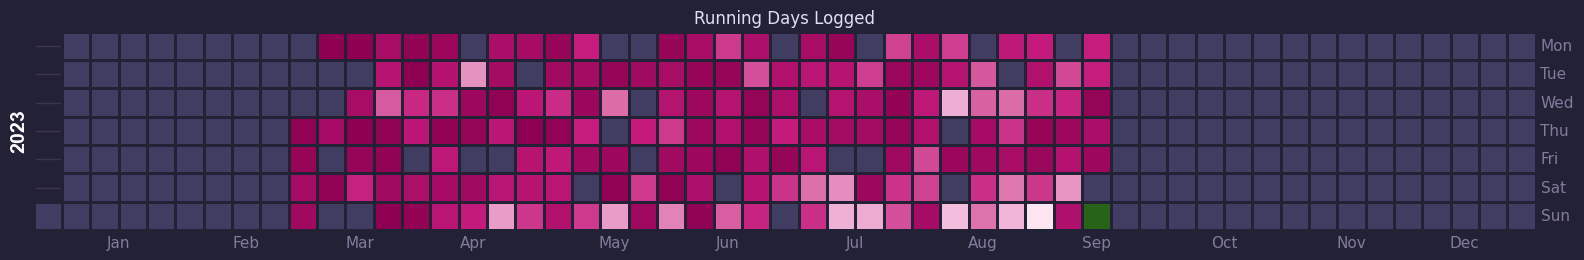

In [172]:
# Plot
plt.figure(figsize=(16, 10), dpi=50)
calmap.calendarplot(
    cm_data,
    vmin=10,
    vmax=60,
    fig_kws={'figsize': (16, 10)},
    yearlabel_kws={'color': 'white', 'fontsize': 14},
    subplot_kws={'title': 'Running Days Logged'},
    cmap = 'PiYG',
    fillcolor='#403C62',  # Adjust the fill color for empty squares
)
plt.show()

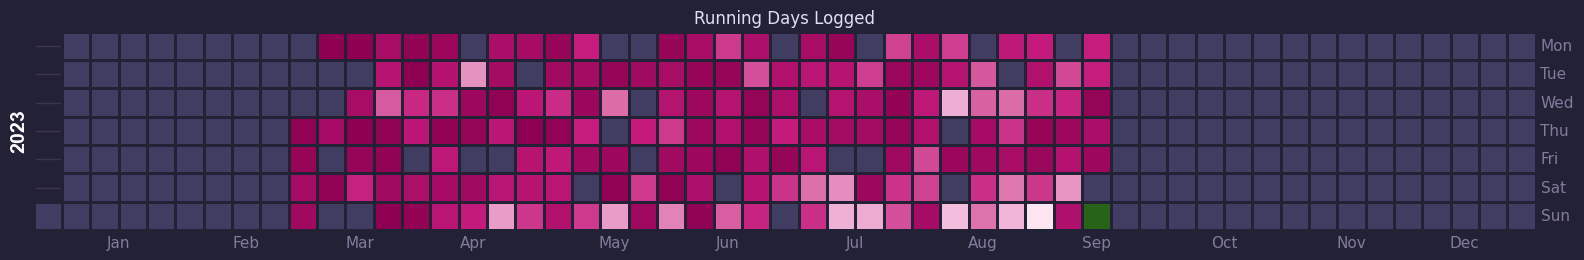

As an inital view, we wanted to see who did the most kms.....

In [98]:
# Group data by runner
total_summary = joined_data.groupby(['Runner']).agg(
            Total_km = ('distance', sum),
            Total_time_min = ('moving_time', sum),
            Total_elevation = ('total_elevation_gain', sum)
        ).reset_index()

# Show results, sort by distance
total_summary.sort_values('Total_km', ascending = False)

,Runner,Total_km,Total_time_min,Total_elevation
4,Tom,1251.45,6916.9,9000.30000
3,Rob,907.25,5817.8,5107.46887
2,Jonny,691.21,3826.9,4914.70000
1,Jack,502.26,2470.4,4724.30000
0,AJ,485.54,2665.7,3443.00000


In [99]:
monthly_summary = joined_data.groupby(['Runner','monthly']).agg(
            Total_km = ('distance', sum),
            Total_time_min = ('moving_time', sum),
            Total_elevation = ('total_elevation_gain', sum)
        ).reset_index()


C:\Users\e014694\AppData\Local\Temp\ipykernel_28044\2741340251.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



<Figure size 12000x13000 with 0 Axes>

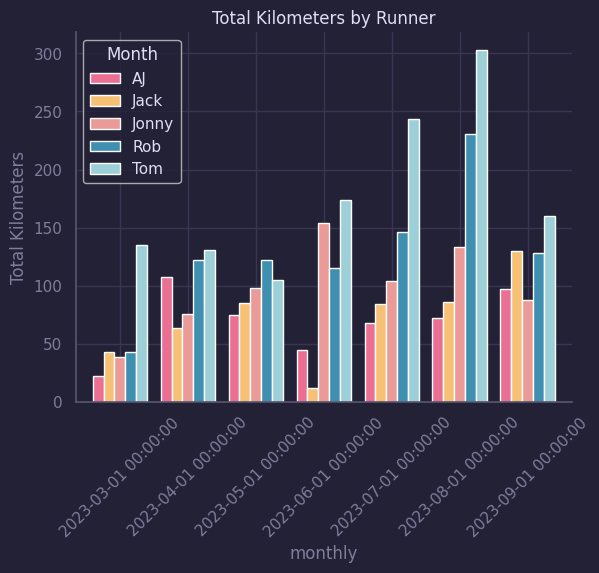

In [102]:
# Set the "rose-pine-moon" style (if available)
plt.style.use('rose-pine-moon')

# Increase figure size
plt.figure(figsize=(120, 130))

monthly_summary.pivot('monthly', 'Runner', 'Total_km').plot.bar(width=0.8)

# Add some text for labels, title, and custom x-axis tick labels, etc.
plt.ylabel('Total Kilometers')
plt.title('Total Kilometers by Runner')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Month', loc='upper left')

#plt.tight_layout()
plt.show()

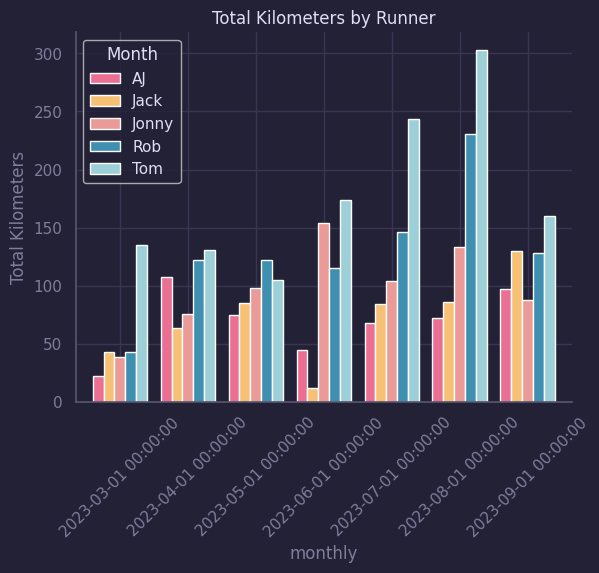

Cumulative Distance

In [104]:
# Sort the DataFrame by 'Runner' and 'monthly'
monthly_summary.sort_values(['Runner', 'monthly'], inplace=True)

# Calculate cumulative total by 'Runner' and 'monthly'
monthly_summary['Cumulative_Total'] = monthly_summary.groupby('Runner')['Total_km'].cumsum()

# Reset the index (optional)
monthly_summary.reset_index(drop=True, inplace=True)

monthly_summary

,Runner,monthly,Total_km,Total_time_min,Total_elevation,Cumulative_Total
0,AJ,2023-03-01,22.13,119.5,109.700000,22.13
1,AJ,2023-04-01,107.10,579.2,245.700000,129.23
2,AJ,2023-05-01,74.53,374.5,576.700000,203.76
3,AJ,2023-06-01,44.37,215.6,227.700000,248.13
4,AJ,2023-07-01,67.85,351.0,830.300000,315.98
5,AJ,2023-08-01,72.54,431.3,406.900000,388.52
6,AJ,2023-09-01,97.02,594.6,1046.000000,485.54
7,Jack,2023-03-01,42.59,205.1,449.500000,42.59
8,Jack,2023-04-01,63.68,297.9,480.600000,106.27
9,Jack,2023-05-01,84.72,399.3,506.100000,190.99


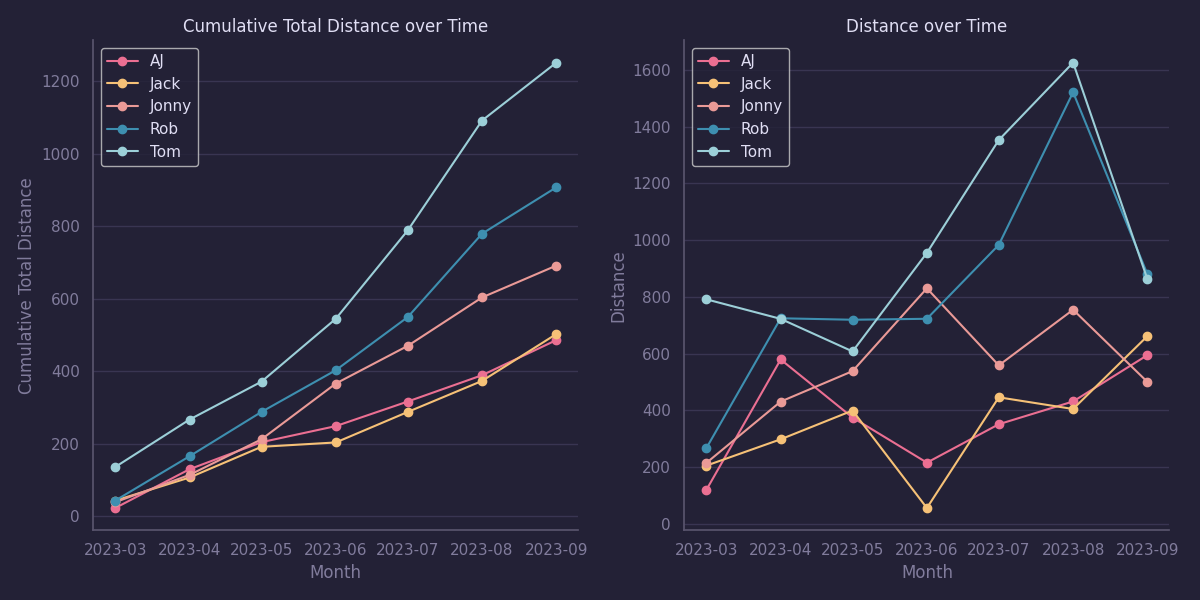

In [135]:
# Set the "rose-pine-moon" style (if available)
plt.style.use('rose-pine-moon')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Cumulative Total Distance over Time
for runner in monthly_summary['Runner'].unique():
    df = monthly_summary[monthly_summary['Runner'] == runner]
    axes[0].plot(df['monthly'], df['Cumulative_Total'], label=runner, marker='o')
    
# Plot 2: Distance over Time
for runner in monthly_summary['Runner'].unique():
    df = monthly_summary[monthly_summary['Runner'] == runner]
    axes[1].plot(df['monthly'], df['Total_time_min'], label=runner, marker='o')

# Set labels and titles
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Cumulative Total Distance')
axes[0].set_title('Cumulative Total Distance over Time')
axes[0].legend(loc='upper left')

axes[1].set_xlabel('Month')
axes[1].set_ylabel('Distance')
axes[1].set_title('Distance over Time')
axes[1].legend(loc='upper left')

# Enable hovering labels using mplcursors
mplcursors.cursor(hover=True)

# Adjust layout
plt.tight_layout()
plt.show()


![Figure 3.png](<attachment:Figure 3.png>)
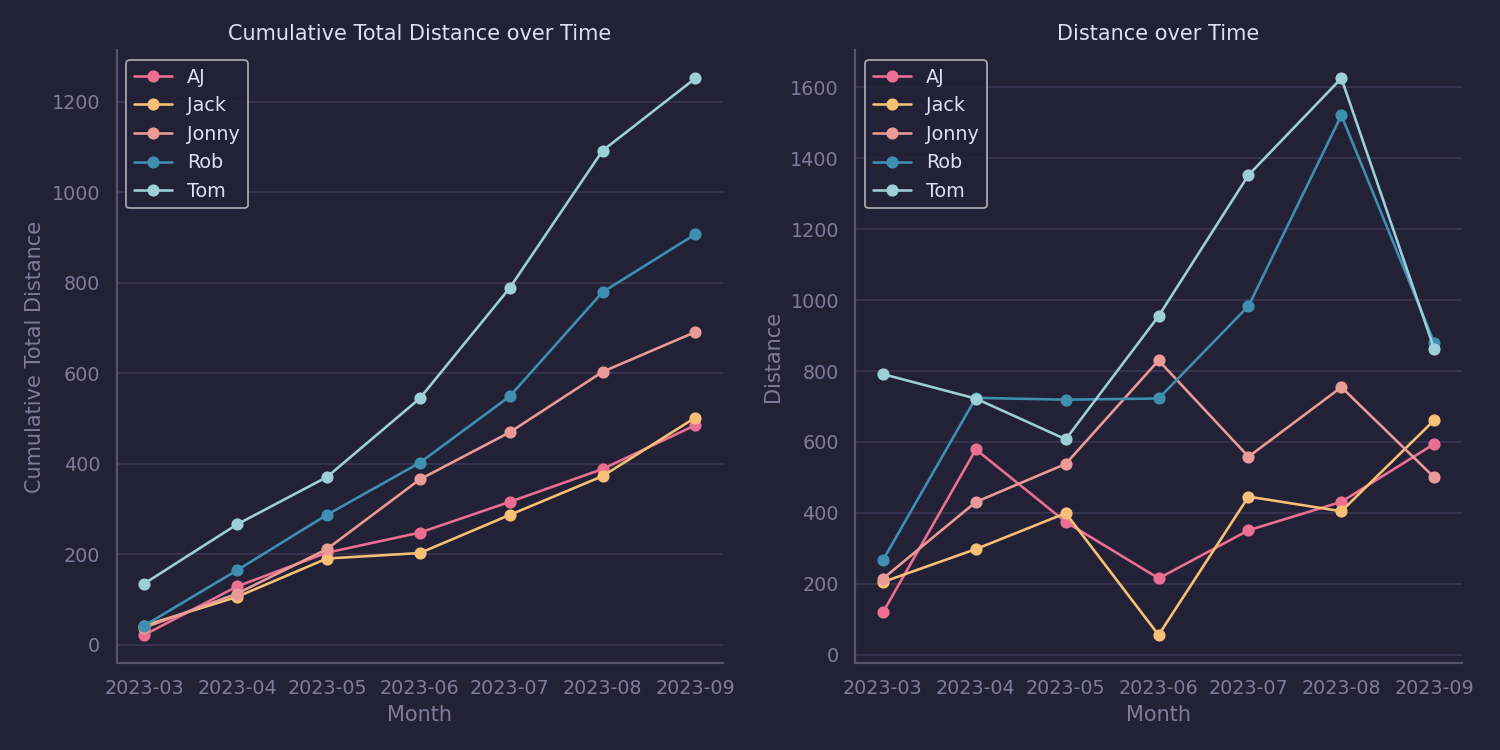

After working through the data I began to think.... Do you think we came close to achieving a Ned Brockman Distance... Well the data speaks for itself

In [1]:
# Calculate the total distance
total_distance = monthly_summary['Total_km'].sum()

def is_ned_brockman(total_distance):

    if total_distance > 3800:
        print ("Yes, you completed ", total_distance, ". Ned Brockman completed")
    else:
        print("No, you losers")

is_ned_brockman(total_distance)

NameError: name 'monthly_summary' is not defined

So how does that look?

In [112]:
# Data
total_distance_km = total_distance 

# Create a DataFrame with latitude and longitude points for the line across Australia
# You can customize these coordinates based on your desired path
path_coordinates = [
    (-31.9894898,115.7414431),  # Start point
    (-31.351245, 131.168932),   # Midpoint to avoid water
    (-33.8923582,151.2729286),  # End Point
]

# Create a DataFrame from the path_coordinates list
path_df = pd.DataFrame(path_coordinates, columns=['Latitude', 'Longitude'])

# Create a Plotly figure with a scatter mapbox trace
fig = go.Figure(go.Scattermapbox(
    lat=path_df['Latitude'],
    lon=path_df['Longitude'],
    mode='lines+markers',
    marker=dict(size=10, color='blue'),  # Marker style
    text=f'Total Distance: {total_distance_km} km',  # Text to display when hovering over the line
))

# Customize the map layout
fig.update_layout(
    mapbox_style="stamen-terrain",  # Map style (you can choose other styles)
    mapbox_zoom=4,  # Zoom level
    mapbox_center={"lat": -27.0, "lon": 126.0},  # Center the map on Australia
    title="Total Collective Distance Across Australia",
)

# Show the plot
fig.show()


# Specify the full file path to save the HTML file
html_file_path = r"###\strava\Rob\Aus_map.html"

# Export the figure as an HTML file to the specified path
pyo.plot(fig, filename=html_file_path)

'C:\\Users\\e014694\\OneDrive - Telstra\\Documents\\strava\\Rob\\Aus_map.html'

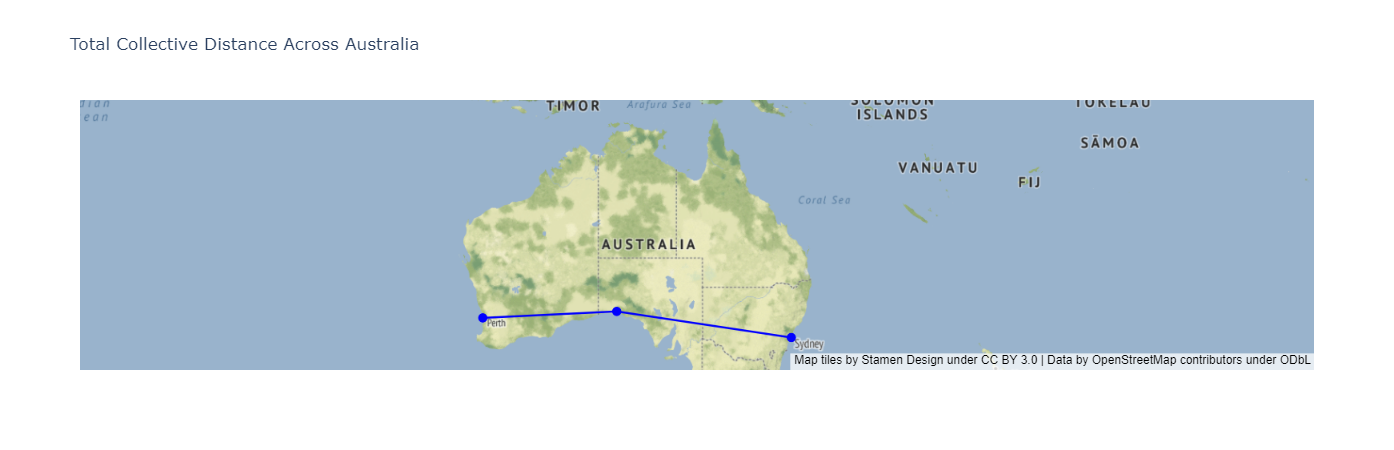